<a href="https://colab.research.google.com/github/kavithasub/uh-study-modules/blob/main/data-science-project/project_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook below contents are covered;

- Imports
- Data Cleaning and Preprocessing
- Exploratory Data Analysis
- Model definition, Training and Prediction
- Performance Optimization and Tuning
- Evaluation and Result Analysis



# Pre requisites

## Imports

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, learning_curve, LearningCurveDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

from sklearn.metrics import accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, classification_report, det_curve, confusion_matrix
from scipy.stats import randint



## Function Definitions

In [146]:
## Method to predict and find accuracy

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

In [147]:
## Function to plot decision boundary

def plot_decision_boundary(model, X, y, ax):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Get predictions
    ab = np.c_[xx.ravel(), yy.ravel()]
    pred = model.predict(ab)

    # Reshape predictions for contour plot
    cc = pred.reshape(xx.shape)

    ax.contourf(xx, yy, cc, cmap='viridis', alpha=0.2)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k')

## Read data file

In [148]:
df = pd.read_csv('/content/drive/MyDrive/sample_data/lung_cancer.csv')

# Data Cleaning and Preprocessing

In [149]:
df.head()

,pid,age,gender,race,smoker,days_to_cancer,stage_of_cancer
0,100001,70,Male,White,Current,NaN,NaN
1,100002,66,Male,White,Current,NaN,NaN
2,100003,64,Male,White,Current,NaN,NaN
3,100004,60,Male,White,Former,NaN,NaN
4,100005,64,Male,White,Former,NaN,NaN


####Description of attributes
pid - anonymous identifier of a person;
age - age of a person at the start of the trial;
gender - Male/Female;
race - the race of a person;

smoker - Former/Current (Former is defined as quit smoking in last 15 years);

days_to_cancer - number of days passed since the trial when the cancer was first observed;

stage_of_cancer - the stage of cancer when the cancer was first observed;

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53427 entries, 0 to 53426
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pid              53427 non-null  int64  
 1   age              53427 non-null  int64  
 2   gender           53427 non-null  object 
 3   race             53166 non-null  object 
 4   smoker           53427 non-null  object 
 5   days_to_cancer   2033 non-null   float64
 6   stage_of_cancer  2032 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ MB


In [151]:
df.shape

(53427, 7)

In [152]:
df.describe()

,pid,age,days_to_cancer
count,53427.000000,53427.000000,2033.000000
mean,149778.048346,61.417448,1047.207083
std,44860.640458,5.023601,743.052899
min,100001.000000,43.000000,0.000000
25%,113363.500000,57.000000,398.000000
50%,126734.000000,60.000000,928.000000
75%,205491.500000,65.000000,1722.000000
max,218894.000000,79.000000,2618.000000


### Get value counts for each attributes

In [153]:
## Get value counts for each attributes
def get_value_counts(dataframe,col_list):
    for col in col_list:
        print(dataframe[col].value_counts())
        print('\n')

In [154]:
get_value_counts(df, ['gender', 'smoker', 'race', 'stage_of_cancer'])

## Result shows value counts are not in other type

gender
Male      31517
Female    21910
Name: count, dtype: int64


smoker
Former     27680
Current    25747
Name: count, dtype: int64


race
White                                        48527
Black or African-American                     2375
Asian                                         1095
More than one race                             678
Native Hawaiian or Other Pacific Islander      192
American Indian or Alaskan Native              190
Participant refused to answer                  109
Name: count, dtype: int64


stage_of_cancer
IA      621
IV      596
IIIB    246
IIIA    213
IB      210
IIB      79
IIA      67
Name: count, dtype: int64




### Check NAN valued attributes

In [155]:
df['stage_of_cancer'].unique()

array([nan, 'IA', 'IIB', 'IV', 'IIIB', 'IIIA', 'IIA', 'IB'], dtype=object)

In [156]:
df['race'].unique()

array(['White', 'Native Hawaiian or Other Pacific Islander',
       'More than one race', 'Asian', nan, 'Black or African-American',
       'American Indian or Alaskan Native',
       'Participant refused to answer'], dtype=object)

In [157]:
df['days_to_cancer'].unique()

array([  nan,  454., 2428., ..., 2220., 1077., 1632.])

In [158]:
df['smoker'].unique()

array(['Current', 'Former'], dtype=object)

### Replace NAN values



In [159]:
df_lung_cancer = df.fillna({'stage_of_cancer':0, 'days_to_cancer':0, 'race':'Other'})
df_lung_cancer.head()

,pid,age,gender,race,smoker,days_to_cancer,stage_of_cancer
0,100001,70,Male,White,Current,0.0,0
1,100002,66,Male,White,Current,0.0,0
2,100003,64,Male,White,Current,0.0,0
3,100004,60,Male,White,Former,0.0,0
4,100005,64,Male,White,Former,0.0,0


### Find missing values
missing data can be removed if very less amount of data else it can be filled with mean values.

In [160]:
df_lung_cancer.isnull().sum()

,0
pid,0
age,0
gender,0
race,0
smoker,0
days_to_cancer,0
stage_of_cancer,0


**There is no missing values in this data set**

### Convert categorical values of stage_of_cancer to 1,2,0

In [161]:
pd.set_option('future.no_silent_downcasting', True)

In [162]:
df_lung_cancer['stage_of_cancer'] = df_lung_cancer['stage_of_cancer'].replace({'IA': 1, 'IB' : 1,'IIA':1,
                                                       'IIB':1,'IIIA':2,'IIIB':2,'IV':2})

In [163]:
df_lung_cancer['stage_of_cancer'].unique()

array([0, 1, 2], dtype=object)

### Apply data trnsform
code will be added after EDA analysis

### Solve inbalanced class problem
code will be added after train_and_split data

# Exploratory Data Analysis

### Plot few graphs to understand interelations of attributes

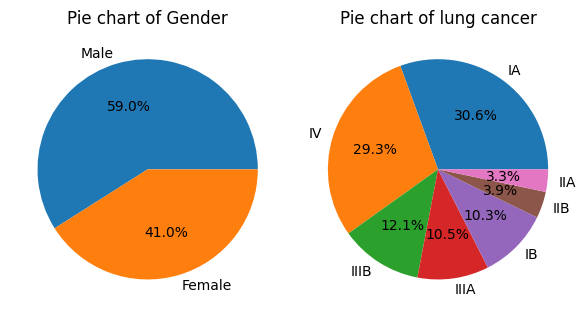

In [164]:
## Draw pie chart for gender and lung cancer distribution
fig,axes = plt.subplots(1,2,figsize=(6,6))
axes[0].pie(df_lung_cancer['gender'].value_counts(),labels=df_lung_cancer['gender'].value_counts().index,autopct='%1.1f%%')
axes[0].set_title('Pie chart of Gender')
axes[1].pie(df['stage_of_cancer'].value_counts(),labels=df['stage_of_cancer'].value_counts().index, autopct='%1.1f%%')
axes[1].set_title('Pie chart of lung cancer')
plt.tight_layout()
plt.show()

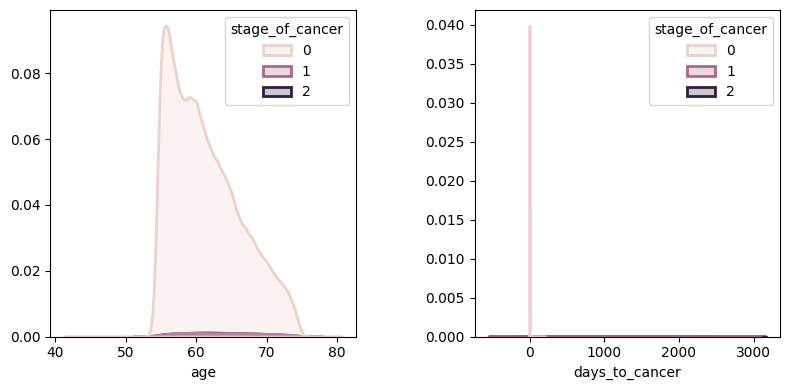

In [165]:
## More plots to see distributions
select_cols = ['stage_of_cancer', 'age', 'days_to_cancer']

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax = ax.flatten()

for i, col in enumerate(df_lung_cancer[select_cols].columns[1:]):
    sns.kdeplot(x=col, data=df_lung_cancer, ax=ax[i], fill=True, lw=2, hue = 'stage_of_cancer')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('')

plt.tight_layout(w_pad=5, h_pad=5)
plt.show()

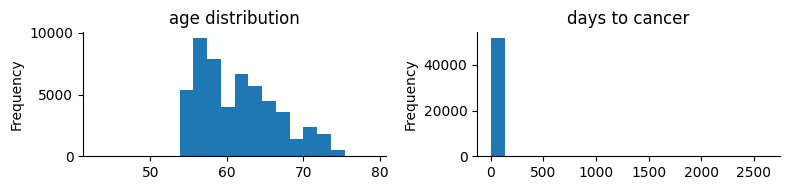

In [166]:
fig,axes = plt.subplots(1,2,figsize=(8,2))

df_lung_cancer['age'].plot(kind='hist', bins=20, title='age distribution', ax=axes[0])
axes[0].spines[['top', 'right',]].set_visible(False)
df_lung_cancer['days_to_cancer'].plot(kind='hist', bins=20, title='days to cancer', ax=axes[1])
axes[1].spines[['top', 'right',]].set_visible(False)


plt.tight_layout()
plt.show()

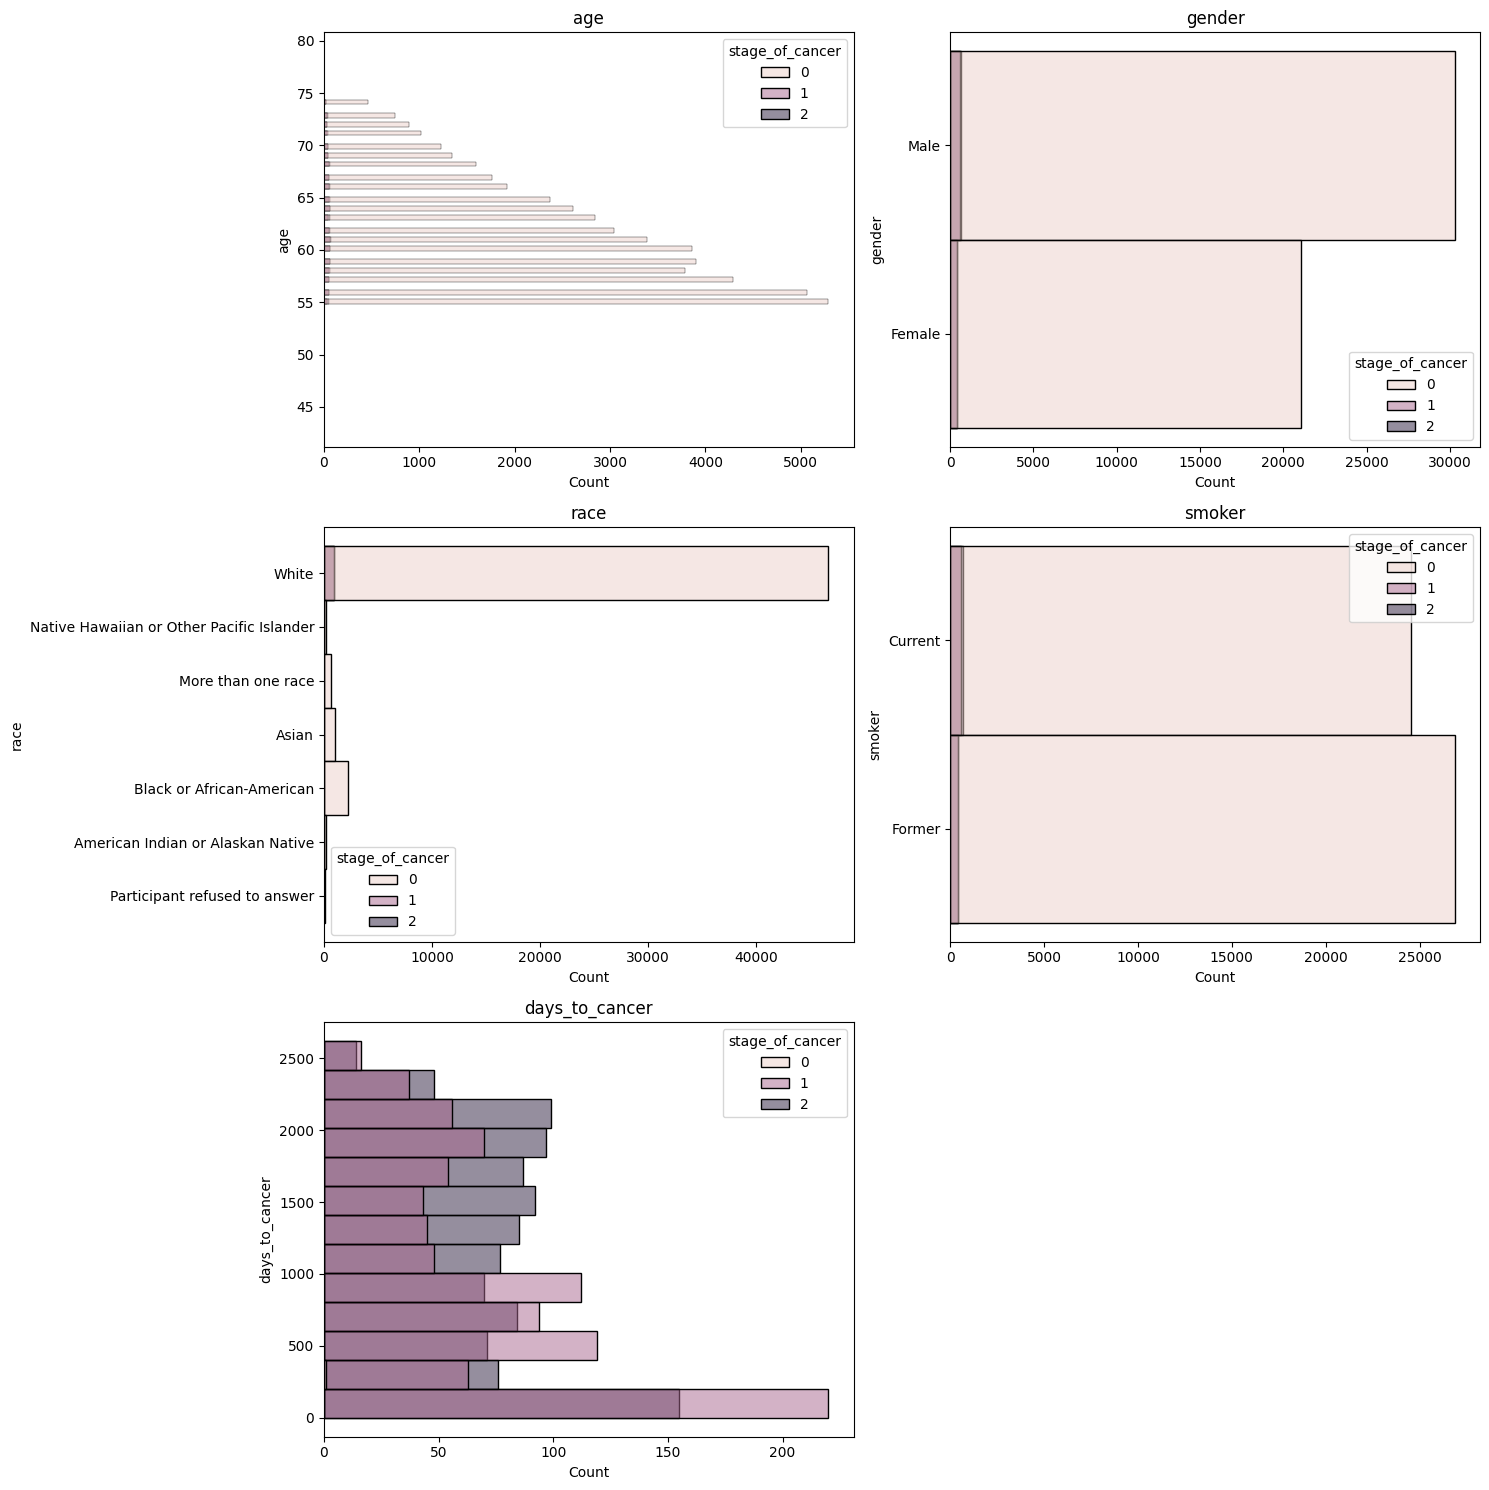

In [167]:
col=['age', 'gender', 'race', 'smoker', 'days_to_cancer']
fig = plt.figure(figsize=(15,15))

for i in range(len(col)):
    plt.subplot(3,2,i+1)
    plt.title(col[i])
    sns.histplot(data=df_lung_cancer,y=df[col[i]],hue='stage_of_cancer')

plt.tight_layout()
plt.show()

###❗Redo analysis with cancer stage 1 and stage 2 due to the stage 0 has high number of records which can cause error

Dataframe with stage 0 (non cancer records) dropped

In [168]:
df_lung_cancer_new = df_lung_cancer[df_lung_cancer['stage_of_cancer'] > 0]

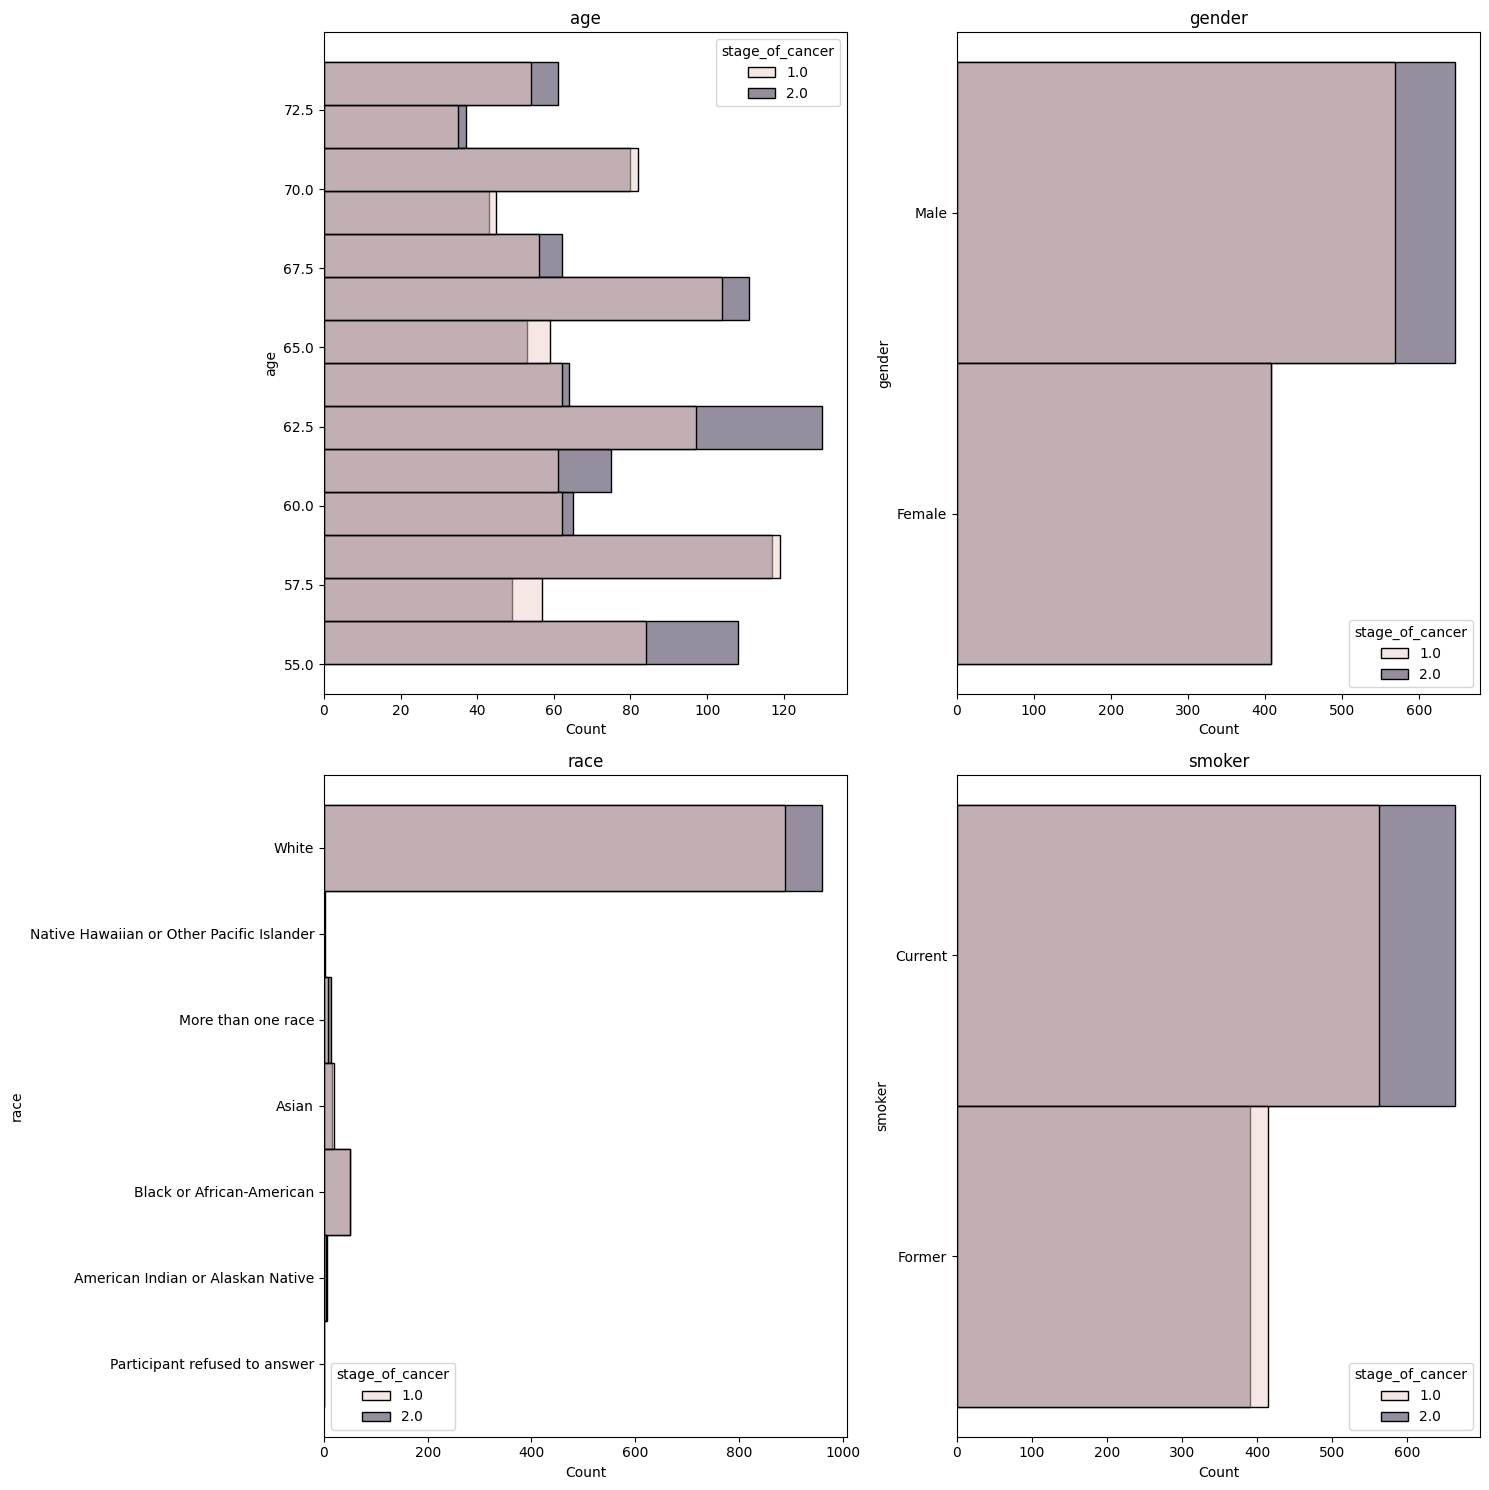

In [169]:
# Histograms of features by stage_of_cancer
cols=['age', 'gender', 'race', 'smoker']
fig = plt.figure(figsize=(15,15))

for i in range(len(cols)):
    plt.subplot(2,2,i+1)
    plt.title(cols[i])
    sns.histplot(data=df_lung_cancer_new, y=df[cols[i]], hue='stage_of_cancer')

plt.tight_layout()
plt.show()

**High stage of cancer found in male current smokers**

Couldn't plot correlation table(heatmap to see relationship between attributes) because most attributes are catgorical

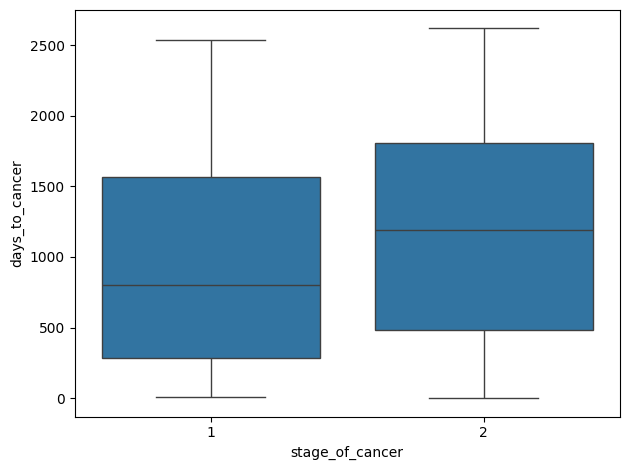

In [170]:
# Find outliers

sns.boxplot(x='stage_of_cancer', y='days_to_cancer', data=df_lung_cancer_new)
plt.tight_layout(w_pad=5, h_pad=5)
plt.show()

### Data transformation

In [171]:
## Encode values for categorical type attributes
category_cols = ['gender', 'race', 'smoker', 'stage_of_cancer']

le = LabelEncoder()
for label in category_cols:
    df_lung_cancer[label] = le.fit_transform(df_lung_cancer[label])
df_lung_cancer.head()

,pid,age,gender,race,smoker,days_to_cancer,stage_of_cancer
0,100001,70,1,7,0,0.0,0
1,100002,66,1,7,0,0.0,0
2,100003,64,1,7,0,0.0,0
3,100004,60,1,7,1,0.0,0
4,100005,64,1,7,1,0.0,0


In [172]:
df_lung_cancer['stage_of_cancer'].unique()

array([0, 1, 2])

# Model definition, Training and Prediction

In [212]:
## Re create dataset with dropped stage 0 (non cancer records)

df_lung_cancer_new = df_lung_cancer[df_lung_cancer['stage_of_cancer'] > 0]

df_lung_cancer_new['stage_of_cancer'].unique()

array([1, 2])

###Split the data into training and test subsets

In [213]:
## Separate target variable from features
X = df_lung_cancer_new.drop(['pid','stage_of_cancer'],axis=1)
y = df_lung_cancer_new['stage_of_cancer']

In [214]:
## train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)


### Apply standard scaler to transform data to same structure

In [215]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)


## Smoker Lung Cancer Stage Classification Models

### 1. Logistic Regression

In [177]:
## Logistic Regression
lr_model = LogisticRegression(max_iter=1000)


In [178]:
lr_model.fit(X_train_sc, y_train)

LogisticRegression(max_iter=1000)

In [179]:
lr_model.score(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.5243076923076923

In [180]:
lr_pred = lr_model.predict(X_test_sc)

#### Find Measures

In [181]:
## find accuracy on test set
lr_acc = accuracy_score(y_test, lr_pred)

print('Accuracy score on Test: ', lr_acc)

#print('Training Accuracy: ', accuracy_score(X_train_sc, y_train))

Accuracy score on Test:  0.5528255528255528


In [182]:
## find recall and precision scores on test set
lr_rec = recall_score(y_test, lr_pred)
lr_prec = precision_score(y_test, lr_pred)

print('Recall score on Test: ', lr_rec)
print('Precision score on Test: ', lr_prec)

Recall score on Test:  0.4852941176470588
Precision score on Test:  0.5625



 Confusion Matrix: 
 [[ 99 105]
 [ 77 126]] 




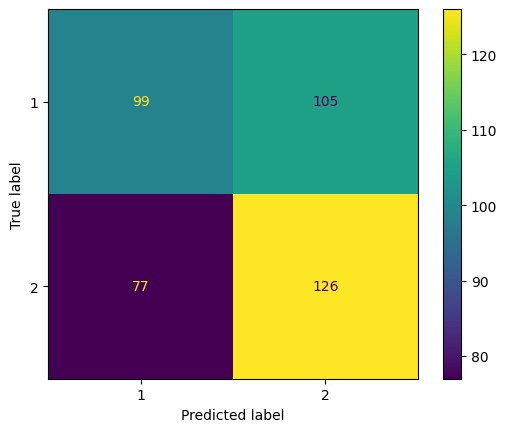

In [183]:
ConfusionMatrixDisplay.from_estimator(lr_model, X_test_sc , y_test);
print('\n Confusion Matrix: \n', confusion_matrix(y_test,lr_pred), '\n\n');

### 2. Random Forest Clasifier

In [184]:
rf_model = RandomForestClassifier(n_estimators=5, random_state=20)


In [185]:
rf_model.fit(X_train_sc , y_train)

RandomForestClassifier(n_estimators=5, random_state=20)

In [186]:
rf_model.score(X_train_sc , y_train)

0.939076923076923

In [187]:
rf_pred = rf_model.predict(X_test_sc)

#### Find Measures

In [188]:
## find accuracy on test set
rf_acc = accuracy_score(y_test , rf_pred)

print('Accuracy score on Test: ', rf_acc)


Accuracy score on Test:  0.4864864864864865


In [189]:
rf_rec = recall_score(y_test, rf_pred)
rf_prec = precision_score(y_test, rf_pred)
print('Recall score of Random Forest Classifier: ', rf_rec)
print('Precision score of Random Forest Classifier: ', rf_prec)

Recall score of Random Forest Classifier:  0.46568627450980393
Precision score of Random Forest Classifier:  0.48717948717948717



 Confusion Matrix for Random Forest: 
 [[ 95 109]
 [100 103]] 




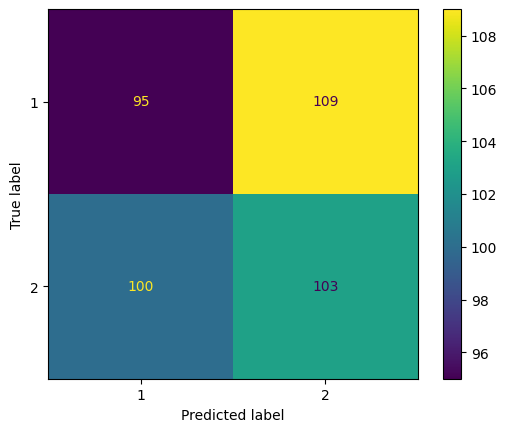

In [190]:
print('\n Confusion Matrix for Random Forest: \n', confusion_matrix(y_test,rf_pred), '\n\n')
ConfusionMatrixDisplay.from_estimator(rf_model , X_test_sc , y_test);

### 3. K-Nearest Neighbours

In [191]:
knn_model = KNeighborsClassifier(n_neighbors=5)

In [192]:
knn_model.fit(X_train_sc, y_train)

KNeighborsClassifier()

In [193]:
knn_model.score(X_train_sc , y_train)

0.7286153846153847

In [194]:
knn_pred = knn_model.predict(X_test_sc)

#### Find Measures

In [195]:
## find accuracy on test set
knn_acc = accuracy_score(y_test , knn_pred)

print('Accuracy score of KNN on Test: ', knn_acc)


Accuracy score of KNN on Test:  0.5135135135135135


In [196]:
knn_rec = recall_score(y_test, knn_pred)
knn_prec = precision_score(y_test, knn_pred)
print('Recall score of KNN: ', knn_rec)
print('Precision score of KNN: ', knn_prec)

Recall score of KNN:  0.47549019607843135
Precision score of KNN:  0.5159574468085106



 Confusion Matrix for KNN: 
 [[ 97 107]
 [ 91 112]] 




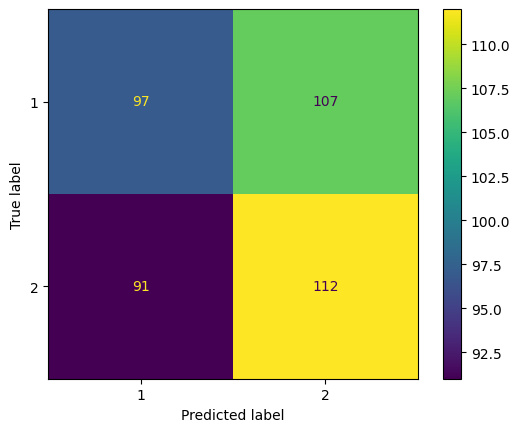

In [197]:
print('\n Confusion Matrix for KNN: \n', confusion_matrix(y_test, knn_pred), '\n\n')
ConfusionMatrixDisplay.from_estimator(knn_model , X_test_sc , y_test);

### Score summary of models

In [198]:
## Display as table
scores = pd.DataFrame(columns = ["LRC", "RFC", "KNN"], index = ["ACC", "REC", "PREC"])
acc = [lr_acc, rf_acc, knn_acc]
scores.iloc[0, :] = acc
rec = [lr_rec, rf_rec, knn_rec]
scores.iloc[1, :] = rec
prec = [lr_prec, rf_prec, knn_prec]
scores.iloc[2, :] = prec
scores

,LRC,RFC,KNN
ACC,0.552826,0.486486,0.513514
REC,0.485294,0.465686,0.47549
PREC,0.5625,0.487179,0.515957


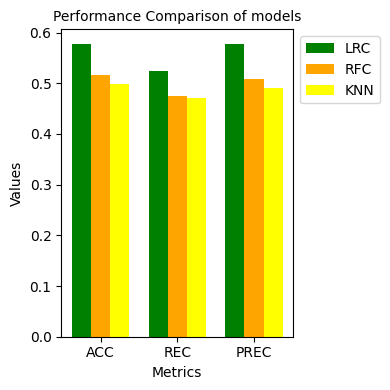

In [52]:
## Bar plot for comparision of performance
x = np.arange(len(scores.index))
bar_width = 0.25

plt.figure(figsize=(4, 4))
plt.bar(x - bar_width, scores['LRC'], bar_width, label='LRC', color='green')
plt.bar(x, scores['RFC'], bar_width, label='RFC', color='orange')
plt.bar(x + bar_width, scores['KNN'], bar_width, label='KNN', color='yellow')

# Adding labels and title
plt.xlabel('Metrics', fontsize=10)
plt.ylabel('Values', fontsize=10)
plt.title('Performance Comparison of models', fontsize=10)
plt.xticks(x, scores.index, fontsize=10)
plt.legend(fontsize=10, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

**So far, comparitively, the accuracy score of Logistic regression model is little high than other models.**

**According to confusion matrix, the number of stage 1 cancer incorrectly predicted as stage 2 cancer (false positive) is comparitively less but, is not considerable difference**

# Performance Optimization and Tuning

### ⭐ Apply K-fold parameter tuning

In [199]:
## Apply K-fold parameter tuning for Random Forest method

scores1 = cross_val_score(RandomForestClassifier(n_estimators=10), X, y, cv=10)

print("Avg Score for Estimators=10 and CV=10 :",np.average(scores1))

scores2 = cross_val_score(RandomForestClassifier(n_estimators=40), X, y, cv=10)

print("Avg Score for Estimators=40 and CV=10 :",np.average(scores2))

scores3 = cross_val_score(RandomForestClassifier(n_estimators=80), X, y, cv=10)

print("Avg Score for Estimators=80 and CV=10 :",np.average(scores3))


Avg Score for Estimators=10 and CV=10 : 0.5486839563411572
Avg Score for Estimators=40 and CV=10 : 0.5486936153771853
Avg Score for Estimators=80 and CV=10 : 0.550661643967932


**Based on above results, increasing n-estimator has little influence on score values hence, we can go with max value n-estimator:80**

In [204]:
## Apply K-fold parameter tuning for Logistic regression method

score_lr=cross_val_score(LogisticRegression(solver='liblinear'), X, y, cv=3)
print(score_lr)
print("Avg :",np.average(score_lr))

[0.59882006 0.56868538 0.58050222]
Avg : 0.5826692171053683


**We can see base model accuracy is 58.72% and K-fold tunned accuracy is 58.26%. So applying k-fold for logistic regression does not influence.**

In [205]:
## Apply K-fold parameter tuning for KNN method

knn = KNeighborsClassifier(n_neighbors=15)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores.mean())

0.5634767700183521


**Seems KNN accuracy increased from 54.29% to 56.34%**

#### ⭐ Find optimal k value

In [202]:
k_range = list(range(10, 70))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
#print(k_scores)

Text(0, 0.5, 'Cross-Validated-Accuracy')

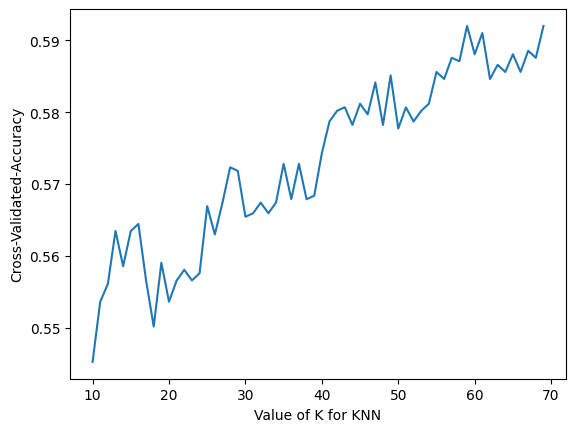

In [203]:
##import matplotlib.pyplot as plt
##%matplotlib inline
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated-Accuracy')

**When k takes 60 tha accuracy score observed above 59% which is little higher than base model. Now we can use this optimal k value for further performance tunings.**

### Using Hyper parameter optimization technique to tune the model

#### Apply Random Search for RF

In [216]:
## Define the parameters for random search
# n_estimators - Number of trees in random forest
# max_depth - Maximum number of levels in tree

param_dist = {'n_estimators': randint(80,500),
              'max_depth': randint(2,30)}

#print(param_dist)
rf_random_model = RandomForestClassifier()


rf_random_search = RandomizedSearchCV(estimator = rf_random_model, param_distributions = param_dist, n_iter=7)

rf_random_search.fit(X_train_sc, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=7,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c8861d757b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c8862c3dde0>})

In [217]:
## Find best params

rf_random_search.best_params_

{'max_depth': 22, 'n_estimators': 303}

**Now we will compare random search tuned model with base model**

In [208]:
## Base model results

base_model_acc = evaluate(rf_model, X_test_sc, y_test)

Model Performance
Average Error: 0.5135 degrees.
Accuracy = 60.93%.


In [218]:
## random search model results

random_best = rf_random_search.best_estimator_
random_model_acc = evaluate(random_best, X_test_sc, y_test)

Model Performance
Average Error: 0.4349 degrees.
Accuracy = 66.58%.


In [219]:
## Compare model results

print('Improvement of {:0.2f}%.'.format( 100 * (random_model_acc - base_model_acc) / base_model_acc))

Improvement of 9.27%.


**We achieved an improvement of 7.61% in accuracy by using random search tuning method. Further, this may be increased using grid search technique.**

#### Apply Grid Search for RF

In [229]:
## Define the parameters for grid search

rf_param_grid = {'n_estimators': [100, 200, 300, 500],
              'max_depth': [10, 15, 20]}

rf_grid_model = RandomForestClassifier()

rf_grid_search = GridSearchCV(estimator = rf_grid_model, param_grid= rf_param_grid, n_jobs= 2)


In [230]:
## Train model and Find best params

rf_grid_search.fit(X_train_sc, y_train)

rf_grid_search.best_params_

{'max_depth': 15, 'n_estimators': 300}

**Evaluting gid search tuned model with base model**

In [231]:
## grid search model results

grid_best = rf_grid_search.best_estimator_
grid_model_acc = evaluate(grid_best, X_test_sc, y_test)

Model Performance
Average Error: 0.4644 degrees.
Accuracy = 64.50%.


In [223]:
## Compare model results

print('Improvement of {:0.2f}%.'.format( 100 * (grid_model_acc - base_model_acc) / base_model_acc))

Improvement of 7.66%.


#### Apply Grid Search for Logistic Regression model



In [232]:
## Define the parameters for grid search
# max_iter - Maximum number of iterations taken for the solvers to converge.
# solver - Algorithm to use in the optimization problem.
# C - Inverse of regularization strength; must be a positive float
# penalty -
lr_param_grid = {'penalty': ['l2'],
              'C': [0.001],
              'solver': ['newton-cg','sag','saga'],
              'max_iter': [1000]}

lr_grid_model = LogisticRegression(random_state=42)

lr_grid_search = GridSearchCV(estimator=lr_grid_model, param_grid=lr_param_grid, n_jobs=2)

In [233]:
## Train model and Find best parameters

lr_grid_search.fit(X_train_sc, y_train)
lr_grid_search.best_params_

{'C': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}

In [234]:
## Find accuracy for grid search LR method

lr_grid_best = lr_grid_search.best_estimator_
lr_grid_model_acc = evaluate(lr_grid_best, X_test_sc, y_test)

Model Performance
Average Error: 0.4595 degrees.
Accuracy = 58.23%.


In [235]:
lr_base_model_acc = evaluate(lr_model, X_test_sc, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (lr_grid_model_acc - lr_base_model_acc) / lr_base_model_acc))

Model Performance
Average Error: 0.4373 degrees.
Accuracy = 65.85%.
Improvement of -11.57%.


**With grid search machanism, LR could not achieve accuracy improvement. Let's try PCA for LR.**

In [241]:
## Apply PCA

pca = PCA(n_components=3)  # Reduce to 3 principal components
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

In [242]:
## Train model with PCA

lr_grid_search.fit(X_train_pca, y_train)

GridSearchCV(estimator=LogisticRegression(random_state=42), n_jobs=2,
             param_grid={'C': [0.001], 'max_iter': [1000], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'sag', 'saga']})

In [243]:
## Find accuracy for grid search LR method with PCA

lr_grid_best_pca = lr_grid_search.best_estimator_
lr_grid_model_acc_pca = evaluate(lr_grid_best_pca, X_test_pca, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (lr_grid_model_acc_pca - lr_base_model_acc) / lr_base_model_acc))

Model Performance
Average Error: 0.4545 degrees.
Accuracy = 58.85%.
Improvement of -10.63%.


**With PCA, there is very little improvement on accuracy of grid search applied method but it is clear that performance tuning is not worked for base model as base model accuracy is still high.**

### Using Neighborhood Components Analysis optimization technique to tune the model

#### Apply NCA for KNN

In [236]:
## Apply Neighborhood Components Analysis

nca = NeighborhoodComponentsAnalysis(random_state=20)
nca.fit(X_train_sc, y_train)

NeighborhoodComponentsAnalysis(random_state=20)

In [237]:
## Transform the data using the learned projection

X_train_nca = nca.transform(X_train_sc)
X_test_nca = nca.transform(X_test_sc)

In [238]:
## Initialize KNN and train on the NCA-transformed training data

knn_model_nca = KNeighborsClassifier(n_neighbors=60)

knn_model_nca.fit(X_train_nca, y_train)

KNeighborsClassifier(n_neighbors=60)

In [239]:
## Evaluate on the test set

knn_acc_nca = evaluate(knn_model_nca, X_test_nca, y_test)

Model Performance
Average Error: 0.4521 degrees.
Accuracy = 63.39%.


In [240]:
knn_base_acc = knn_acc*100
print('Improvement of {:0.2f}%.'.format( 100 * (knn_acc_nca - knn_base_acc) / knn_base_acc))

Improvement of 23.44%.


**By applying NCA for KNN it is observed that accuracy has been improved by 26.02% from KNN base model**

**But, this can not prove that KNN is best model because Random forest model accuracy is increased to 71.50% after performance optimization with random search hyper parameter.**

**Considering this fact, we can choose Random forest model is the best model for lung cancer stage analysis in terms of accuracy.**

# Evaluation and Result Analysis

### Clasification reports

In [78]:
print('classification report - Logistic Regression\n Base model\n\n', classification_report(y_test , lr_pred))

classification report - Logistic Regression
 Base model

               precision    recall  f1-score   support

           1       0.58      0.53      0.55       200
           2       0.58      0.63      0.60       207

    accuracy                           0.58       407
   macro avg       0.58      0.58      0.58       407
weighted avg       0.58      0.58      0.58       407



In [244]:
rf_pred_tunned = rf_random_search.predict(X_test_sc)
print('classification report - Random Forest\n Tunned model\n\n', classification_report(y_test , rf_pred_tunned))

classification report - Random Forest
 Tunned model

               precision    recall  f1-score   support

           1       0.56      0.53      0.54       200
           2       0.57      0.60      0.59       207

    accuracy                           0.57       407
   macro avg       0.56      0.56      0.56       407
weighted avg       0.56      0.57      0.56       407



In [86]:
knn_pred_tunned = knn_model_nca.predict(X_test_nca)
print('classification report -  KNN\n Tunned model\n\n', classification_report(y_test , knn_pred_tunned))

classification report -  KNN
 Tunned model

               precision    recall  f1-score   support

           1       0.54      0.51      0.52       200
           2       0.55      0.58      0.57       207

    accuracy                           0.55       407
   macro avg       0.55      0.54      0.54       407
weighted avg       0.55      0.55      0.54       407



### Feature importants


Random Forest Feature Importance:


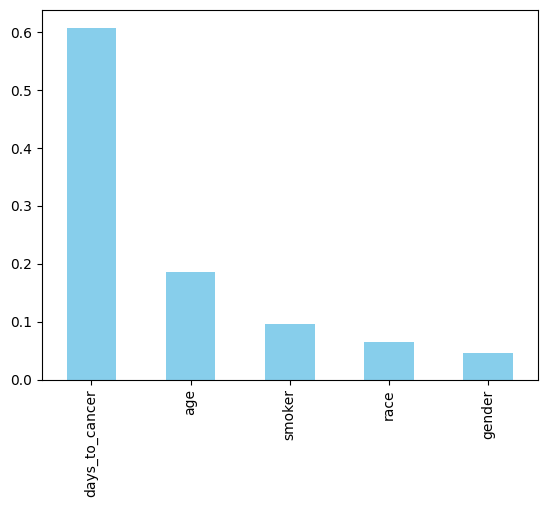

In [89]:
## Find feature importance for Random Forest classifier

if hasattr(random_best, 'feature_importances_'):
    feature_importance_rf = pd.Series(random_best.feature_importances_,
                                      index=X.columns).sort_values(ascending=False)
    print("\nRandom Forest Feature Importance:")
    #print(feature_importance_rf)
    feature_importance_rf.plot.bar(color='skyblue')

In [ ]:
## Find feature importance for KNN classifier

if hasattr(random_best, 'feature_importances_'):
    feature_importance_rf = pd.Series(random_best.feature_importances_,
                                      index=X.columns).sort_values(ascending=False)
    print("\nRandom Forest Feature Importance:")
    #print(feature_importance_rf)
    feature_importance_rf.plot.bar(color='skyblue')

### Decision boundry analysis

In [130]:
## split data again with two features
# selected features which most importants

# Separate target variable from features
X_new = df_lung_cancer_new.drop(['pid', 'gender', 'race', 'smoker', 'stage_of_cancer'], axis=1)
y_new = df_lung_cancer_new['stage_of_cancer']

X_new.head()

,age,days_to_cancer
11,61,454.0
48,74,2428.0
54,67,148.0
146,68,491.0
157,65,795.0


In [128]:
X_new['smoker'].unique()

array([0, 1])

In [131]:
# train and test data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.2, shuffle=True)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_sc_new = sc.fit_transform(X_train_new)
X_test_sc_new = sc.transform(X_test_new)

In [132]:
rf_random_search.fit(X_train_sc_new, y_train_new)

random_best_new = rf_random_search.best_estimator_
random_model_acc_new = evaluate(random_best_new, X_test_sc_new, y_test_new)

Model Performance
Average Error: 0.4226 degrees.
Accuracy = 68.06%.


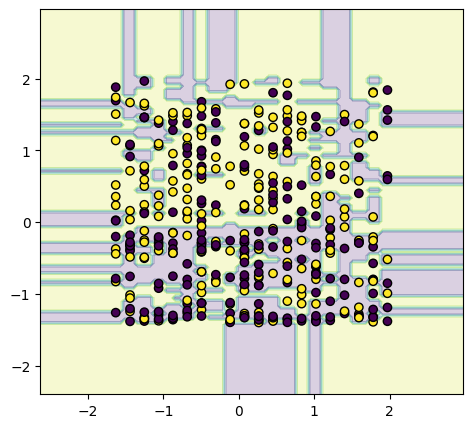

In [135]:
## Plot decision boundry for random forest best model

plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 2, 1)
plot_decision_boundary(random_best_new, X_test_sc_new, y_test_new, ax1)

### Learning curve

In [138]:
## check training sample size vs accuracy

train_size_abs, train_scores, test_scores = learning_curve(random_best, X_train_sc, y_train, train_sizes=[0.3, 0.6, 0.9])
for train_size, cv_train_scores, cv_test_scores in zip(
    train_size_abs, train_scores, test_scores):
    print(f"{train_size} samples were used to train the model")
    print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
    print(f"The average test accuracy is {cv_test_scores.mean():.2f}")

390 samples were used to train the model
The average train accuracy is 0.76
The average test accuracy is 0.56
780 samples were used to train the model
The average train accuracy is 0.71
The average test accuracy is 0.58
1170 samples were used to train the model
The average train accuracy is 0.67
The average test accuracy is 0.58


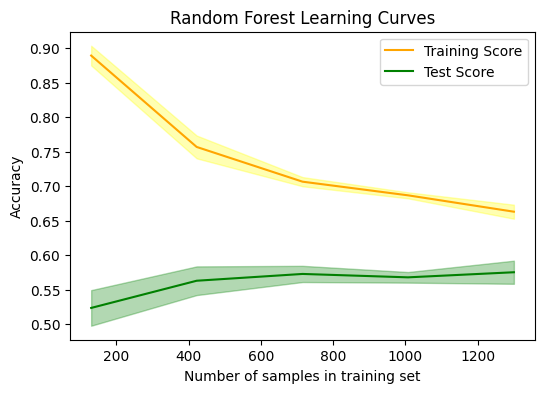

In [144]:
## Plot learning curve for RF

#Generate the data needed to plot a learning curve
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(random_best, X_train_sc, y_train)
train_mean_rf = np.mean(train_scores_rf, axis=1)
train_std_rf = np.std(train_scores_rf, axis=1)
test_mean_rf = np.mean(test_scores_rf, axis=1)
test_std_rf = np.std(test_scores_rf, axis=1)

# plot learning curve
plt.figure(figsize=(6, 4))
plt.plot(train_sizes_rf, train_mean_rf, label='Training Score', color='orange')
plt.fill_between(train_sizes_rf, train_mean_rf - train_std_rf, train_mean_rf + train_std_rf, color='yellow', alpha=0.3)
plt.plot(train_sizes_rf, test_mean_rf, label='Test Score', color='green')
plt.fill_between(train_sizes_rf, test_mean_rf - test_std_rf, test_mean_rf + test_std_rf, color='green', alpha=0.3)
plt.title('Random Forest Learning Curves')
plt.xlabel('Number of samples in training set')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Receiver operating characteristic (ROC)

### nnn